In [1]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import os
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import quantstats

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)

In [27]:
base_dir = os.path.join('C:/','workspace','project_quant')
note_dir = os.path.join(base_dir, 'note')
strategy_dir = os.path.join(base_dir, 'strategy')
index_data_dir = os.path.join(base_dir,'data','index_data')

In [28]:
np.random.seed(180)

start_date='2010-01-01'
end_date='2021-10-30'

In [29]:
def load_index_data(start_date, end_date, input_dir, input_excel_file_name, col_name):
    if input_excel_file_name[-4:]=='xlsx':
        input=pd.read_excel(os.path.join(input_dir,input_excel_file_name), index_col='Date')
        input=input.sort_index(ascending=False)
    elif input_excel_file_name[-4:]=='.csv':
        input=pd.read_csv(os.path.join(input_dir,input_excel_file_name), index_col='Date')
        input=input.sort_index(ascending=False)

    # input=input.drop(['CHG_PCT_1D'],axis=1)
    index_df=input.iloc[:,0].resample('1D').last().pct_change().fillna(0)
    index_df.rename(col_name, inplace=True)
    index_df=index_df.loc[start_date: end_date]
    return index_df

In [30]:
dm_stock=load_index_data(start_date, end_date,index_data_dir, 'MSCI World.xlsx', 'dm_stock')
em_stock=load_index_data(start_date, end_date,index_data_dir, 'MSCI Emerging.xlsx', 'em_stock')
fixed_income=load_index_data(start_date, end_date,index_data_dir, 'Bloomberg Barclays Global AGG.xlsx', 'fixed_income')
commodity=load_index_data(start_date, end_date,index_data_dir, 'SNP GSCI TR.xlsx', 'commodity')
return_df=pd.concat([dm_stock,em_stock,fixed_income,commodity], axis=1).fillna(0)
return_df

,dm_stock,em_stock,fixed_income,commodity
Date,,,,
2010-01-01,0.000000,0.000000,0.000000,0.000000
2010-01-02,0.000000,0.000000,0.000000,0.000000
2010-01-03,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.017904,0.015200,0.005028,0.025407
2010-01-05,0.002943,0.010702,0.002859,0.000989
...,...,...,...,...
2021-10-26,0.002392,-0.000925,-0.000068,0.002605
2021-10-27,-0.004859,-0.010162,0.003900,-0.013486
2021-10-28,0.008690,-0.005316,0.001352,-0.001364


In [31]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected Annual return
    ret[x] = np.sum((return_df.mean() * weights * 252))
    # Expected Annual volatility
    vol[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    # Sharpe Ratio assuming risk free rate is 1.5%
    sharpe[x] = (ret[x]-0.015)/vol[x]

In [32]:
print("Max return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(ret.argmax(), round(100*ret.max(),2), round(sharpe[ret.argmax()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, commodity {}".format(all_weights[ret.argmax(),0], all_weights[ret.argmax(),1], all_weights[ret.argmax(),2], all_weights[ret.argmax(),3]))
print("########################################################################################################")

print("Max risk adjusted return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(sharpe.argmax(), round(100*ret[sharpe.argmax()],2), round(sharpe.max(),2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, commodity {}".format(all_weights[sharpe.argmax(),0], all_weights[sharpe.argmax(),1], all_weights[sharpe.argmax(),2], all_weights[sharpe.argmax(),3]))
print("########################################################################################################")

print("Min risk portfolio")
print("#{} with annual return {}% and sharpe {} ".format(vol.argmin(), round(100*ret[vol.argmin()],2), round(sharpe[vol.argmin()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, commodity {}".format(all_weights[vol.argmin(),0], all_weights[vol.argmin(),1], all_weights[vol.argmin(),2], all_weights[vol.argmin(),3]))
print("########################################################################################################")


Max return portfolio
#9813 with annual return 6.29% and sharpe 0.4 
developed market stock:0.9378694266566124, emerging market stock:0.01634674336230447, global bond:0.03290778076507156, commodity 0.01287604921601149
########################################################################################################
Max risk adjusted return portfolio
#7157 with annual return 5.5% and sharpe 0.41 
developed market stock:0.7718643345013085, emerging market stock:0.004116581065637395, global bond:0.2189460659349427, commodity 0.0050730184981113945
########################################################################################################
Min risk portfolio
#3933 with annual return 1.71% and sharpe 0.06 
developed market stock:0.00266604750267581, emerging market stock:0.02520299860470433, global bond:0.9464827202139799, commodity 0.025648233678639866
########################################################################################################


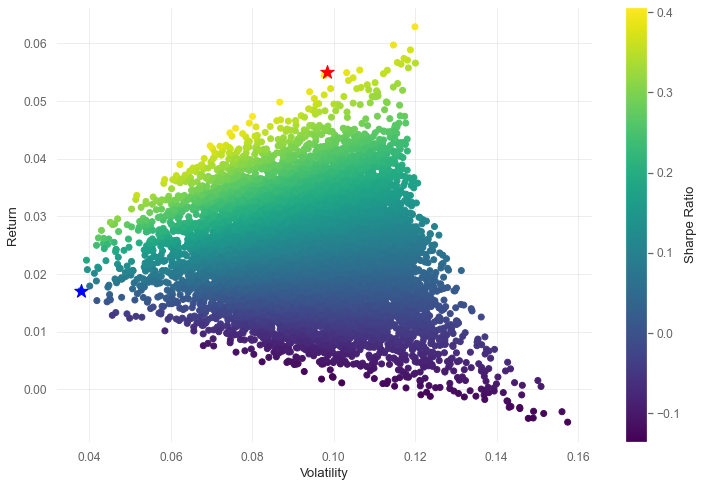

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol[sharpe.argmax()], ret[sharpe.argmax()], c='red', s=200, marker="*") # red star means max sharpe return
plt.scatter(vol[vol.argmin()], ret[vol.argmin()], c='blue', s=200, marker="*") # blue star means min volatility
plt.show()

In [34]:
def get_ret_vol_sharpe(weights):
    weights = np.array(weights)
    ret = np.sum(return_df.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    sharpe = (ret-0.015)/vol
    return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

def neg_sharpe(weights):
    # to use convex optimization, change sign to minus to solve minimization problem.
    return get_ret_vol_sharpe(weights)['sharpe'] * -1

def min_vol(weights):
    # to use convex optimization, finding minimum volatility doesn't require sign change
    return get_ret_vol_sharpe(weights)['volatility']

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [35]:
cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
initial = [0.25, 0.25, 0.25, 0.25] # 1/N weight for default

optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
print(optimizer)
print("Max Sharp portfolio consists of {}% of dm stock, {}% of em stock, {}% of fixed income, {}% of commodity".format(round(100*optimizer.x[0],2), round(100*optimizer.x[1],2), round(100*optimizer.x[2],2), round(100*optimizer.x[3],2),))

     fun: -0.41075937587681427
     jac: array([-0.15366953,  0.13993851, -0.1539274 ,  0.45968134])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.77182855, 0.        , 0.22817145, 0.        ])
Max Sharp portfolio consists of 77.18 of dm stock, 0.0 of em stock, 22.82 of fixed income, 0.0 of commodity


In [37]:
frontier_y = np.linspace(ret.min(), ret.max(), 200)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sharpe(w)['return'] - possible_return})

    result = minimize(min_vol, initial, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

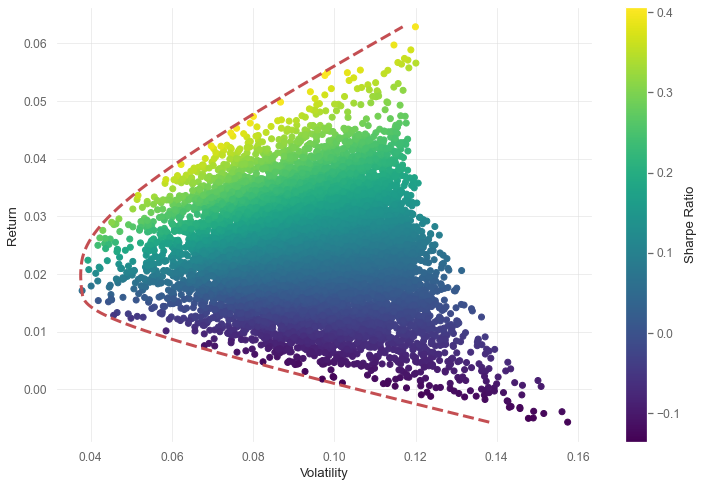

In [38]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.show()